# Homework 4: machine learning

---
### NOTE: Sometimes we refer to [the original work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) 

---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

You need to install `scikit v0.18`: `conda update scikit-learn`

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Read and minimal cleanup: for the first part, we need the labels (i.e. colour ratings), so we can't use the points where they don't exist. 

Since we will later `aggregate` the players, it is **important** to note that this doesn't produce inconsistencies because `dyads` is constructed by a join between a `players` table and a `referees` table, so it is natural that the missing values are missing for all instances of a player.

In [3]:
dyads = pd.read_csv("CrowdstormingDataJuly1st.csv", index_col=0)
print(dyads.shape)

dyads.dropna(subset=['rater1'], inplace=True)
print(dyads.shape)

# since both values are missing at the same time, this should be 0:
print(dyads.rater2.isnull().sum())

# the groupby object user later on
group_players = dyads.groupby(level=0)

(146028, 27)
(124621, 27)
0


Let's see the numbers: 

<sub>yes, they were done by the other guys, but it's useful to have them at hand:</sub>

Also, they were excluding some referees that have been _carried over_, and that only removes ~3% of the data. Since we're not doing statistics on referees, we won't drop them. Every little data helps :)

In [4]:
print("Number of players: " , dyads.index.unique().size)
print("Number of referees: ", dyads.refNum.unique().size)

Number of players:  1585
Number of referees:  2978


The original analysis mentioned that "*the two raters disagree on 28742 or 19% of the time*". Since there are only 1585 players, it means they ran it on the `dyads` set. _**WHY?**_ That doesn't make sense, so let's just check that the ratings for each player are consistent:

for the group of each player, we check that the number of values in `raterX` is **exactly** one:

In [5]:
def build_player_consitency(player_df):
    """ Needs to return a Series of {col_name: col_value}. """
    return pd.Series({col+"_INconsistent" : (player_df[col].unique().size != 1) 
                                             for col in ['rater1', 'rater2'] })
consistency = group_players.apply(build_player_consitency)
print("Rater1 has been inconsistent %d times" % consistency.rater1_INconsistent.sum())
print("Rater2 has been inconsistent %d times" % consistency.rater2_INconsistent.sum())

Rater1 has been inconsistent 0 times
Rater2 has been inconsistent 0 times


OK, so they _ARE_ consistent. This means that their statistic doesn't account for players who have more matches than others, so the numbers are skewed. Let's check again, this time on _unique_ players

In [6]:
player_ratings = group_players.agg({'rater1':'first', 'rater2':'first'})
diffs = player_ratings.rater1 - player_ratings.rater2
print("The raters disagree for {p:.3f}% of the players".format(p=(diffs != 0).sum() / len(diffs) ))

print("Diffs std dev: ", diffs.std())

max_diff = diffs.abs().max()
num_occur = (diffs.abs() == max_diff).sum()
print("Max disagreement value {0}, occuring {1} times".format(max_diff * 4, num_occur)) # *4 to pass from float to int

The raters disagree for 0.239% of the players
Diffs std dev:  0.11594303556667578
Max disagreement value 2.0, occuring 2 times


So this means:
  1. that there is slightly more agreement between the raters for players who have more entries in `dyads` i.e. who played under more referees
  2. that if we use both labels, using `accuracy` as a measure of performance is not a very good idea. Keep in mind that the differences are not ordered, so it could have an impact double as big on the accuracy, i.e. at most $1 - 2 * \mathit{disagreementPercentage} = 1 - 2 * 0.24 \approx 0.5 $

#### Curiosity
Who are the 'controversial' guys :) ?

In [7]:
diffs[diffs.abs() == max_diff]

playerShort
kyle-walker    -0.5
mario-goetze   -0.5
dtype: float64

<img style='float:left' alt='Kyle-walker' src='http://www.thefootballsocial.co.uk/images/players/Tottenham%20Hotspur/Kyle%20Walker.jpg' /> <img alt='Mario_Goetze' src='http://i0.web.de/image/176/31756176,pd=2/mario-goetze.jpg' width=300/>

## Feature selection

In [8]:
dyads.columns

Index(['player', 'club', 'leagueCountry', 'birthday', 'height', 'weight',
       'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

### Aggregation

Here's how we aggregate the data for each player:
<table>
<tr><th>Variable</th><th>Method</th><th>Fill NA</th></tr>
<tr><td>`height`, `weight`</td><td>first</td><td>average</td></tr>
<tr><td>`games`</td><td>sum</td></tr>
<tr><td>`goals`</td><td>sum ; percentage in games</td></tr>
<tr><td>`victories`, `ties`, `defeats`</td><td>sum ; percentage in games</td></tr>
<tr><td>`redCards`, `yellowCards`, `yellowReds`</td><td>sum ; percentage in games</td></tr>
</table>


In [9]:
players = group_players.agg({'height':'first', 'weight':'first', 'games':'sum', 
                             'victories':'sum','defeats':'sum', 'ties': 'sum', 'goals':'sum', 
                             'redCards':'sum', 'yellowReds': 'sum', 'yellowCards':'sum'})

# fill by average
av_height = players['height'].mean()
av_weight = players['weight'].mean()
players['height'].fillna(value=av_height, inplace=True)
players['weight'].fillna(value=av_weight, inplace=True)

print(players.shape)
players.head()

(1585, 10)


,yellowReds,weight,yellowCards,ties,victories,redCards,goals,games,defeats,height
playerShort,,,,,,,,,,
aaron-hughes,0,71.0,19,179,247,0,9,654,228,182.0
aaron-hunt,0,73.0,42,73,141,1,62,336,122,183.0
aaron-lennon,0,63.0,11,97,200,0,31,412,115,165.0
aaron-ramsey,0,76.0,31,42,150,1,39,260,68,178.0
abdelhamid-el-kaoutari,4,73.0,8,40,41,2,1,124,43,180.0


Although the original study shows there is little information in the EAT, IAT variables, we choose to use everything for now, and let the algorithm decide what's important or not.

If these values were to have any relevance, we'd expect them to be correlated with the number of cards a player gets: the higher the values, the more cards they'd get if they're darker in colour. So we add that correlation as a feature: i.e. the higher the correlation, the bigger the probability is they've a dark skin


In [10]:
c = group_players.corr()

In [11]:
for racism in ['meanIAT', 'meanExp']:
    for card in ['redCards', 'yellowCards', 'yellowReds']:
        a = c.loc[c.index.get_level_values(1)==racism, card].reset_index(level=1).fillna(value=0)
        players['cor_'+racism+card] = a[card]
players.head()

,yellowReds,weight,yellowCards,ties,victories,redCards,goals,games,defeats,height,cor_meanIATredCards,cor_meanIATyellowCards,cor_meanIATyellowReds,cor_meanExpredCards,cor_meanExpyellowCards,cor_meanExpyellowReds
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,0,71.0,19,179,247,0,9,654,228,182.0,0.000000,-0.084032,0.000000,0.000000,-0.082210,0.000000
aaron-hunt,0,73.0,42,73,141,1,62,336,122,183.0,-0.055174,-0.162927,0.000000,-0.066079,-0.197755,0.000000
aaron-lennon,0,63.0,11,97,200,0,31,412,115,165.0,0.000000,-0.156448,0.000000,0.000000,-0.127625,0.000000
aaron-ramsey,0,76.0,31,42,150,1,39,260,68,178.0,-0.037021,-0.135808,0.000000,-0.071047,-0.161982,0.000000
abdelhamid-el-kaoutari,4,73.0,8,40,41,2,1,124,43,180.0,0.016348,0.035919,0.059003,0.000514,0.001129,0.040668


### Normalisation

First, we create extra features by normalizing to the number of games (always $\neq 0$).

Then we normalise all features

In [12]:
(players.games == 0).sum()

0

In [13]:
percentage_features = ['victories', 'ties', 'defeats', 'redCards', 'yellowReds', 'yellowCards']
for feature in percentage_features:
    players['percentage_'+feature] = players[feature] / players['games']
players.head()

,yellowReds,weight,yellowCards,ties,victories,redCards,goals,games,defeats,height,...,cor_meanIATyellowReds,cor_meanExpredCards,cor_meanExpyellowCards,cor_meanExpyellowReds,percentage_victories,percentage_ties,percentage_defeats,percentage_redCards,percentage_yellowReds,percentage_yellowCards
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0,71.0,19,179,247,0,9,654,228,182.0,...,0.000000,0.000000,-0.082210,0.000000,0.377676,0.273700,0.348624,0.000000,0.000000,0.029052
aaron-hunt,0,73.0,42,73,141,1,62,336,122,183.0,...,0.000000,-0.066079,-0.197755,0.000000,0.419643,0.217262,0.363095,0.002976,0.000000,0.125000
aaron-lennon,0,63.0,11,97,200,0,31,412,115,165.0,...,0.000000,0.000000,-0.127625,0.000000,0.485437,0.235437,0.279126,0.000000,0.000000,0.026699
aaron-ramsey,0,76.0,31,42,150,1,39,260,68,178.0,...,0.000000,-0.071047,-0.161982,0.000000,0.576923,0.161538,0.261538,0.003846,0.000000,0.119231
abdelhamid-el-kaoutari,4,73.0,8,40,41,2,1,124,43,180.0,...,0.059003,0.000514,0.001129,0.040668,0.330645,0.322581,0.346774,0.016129,0.032258,0.064516


Whiten the data (0 mean, unit variance):

In [14]:
players = (players - players.mean()) / players.std()

### Categorisation

There are different views about categorical features (strings) since `sklearn` treats them as numbers. The best practice is to `one-hot encode` them but many argue that simply putting them to integer values doesn't affect the results as much. See [the discussion on the mailing list](https://www.mail-archive.com/search?l=scikit-learn-general%40lists.sourceforge.net&q=subject%3A%22Re%5C%3A+%5C%5BScikit%5C-learn%5C-general%5C%5D+Random+Forest+with+a+mix+of+categorical+and+lexical+features%22&o=newest&f=1)

We will follow the best practice and binarise them, since there are not that many values

---

Is is safe to keep the first values for `club`, `position` ?

In [15]:
# categories = group_players.agg(['club', 'leagueCountry', 'position']).first()
clubs     = group_players.apply(lambda x: len(x.club.unique()))     # get number of clubs
positions = group_players.apply(lambda x: len(x.position.unique())) # get number of positions
print("number of players with more than 1 club: "    , (clubs     != 1).sum())
print("number of players with more than 1 position: ", (positions != 1).sum())

number of players with more than 1 club:  0
number of players with more than 1 position:  0


Yes, it is

In [16]:
categories = group_players.agg({'club': 'first', 'leagueCountry':'first', 'position':'first'})
players_wcats = pd.get_dummies(players.join(categories))
players_wcats.columns.tolist()

# it's useful to see all the features now, but if long output is annoying for you as well, you can 
# click on the margin of the cell to toggle its scrolling (or double click to hide it ;) )

['yellowReds',
 'weight',
 'yellowCards',
 'ties',
 'victories',
 'redCards',
 'goals',
 'games',
 'defeats',
 'height',
 'cor_meanIATredCards',
 'cor_meanIATyellowCards',
 'cor_meanIATyellowReds',
 'cor_meanExpredCards',
 'cor_meanExpyellowCards',
 'cor_meanExpyellowReds',
 'percentage_victories',
 'percentage_ties',
 'percentage_defeats',
 'percentage_redCards',
 'percentage_yellowReds',
 'percentage_yellowCards',
 'position_Attacking Midfielder',
 'position_Center Back',
 'position_Center Forward',
 'position_Center Midfielder',
 'position_Defensive Midfielder',
 'position_Goalkeeper',
 'position_Left Fullback',
 'position_Left Midfielder',
 'position_Left Winger',
 'position_Right Fullback',
 'position_Right Midfielder',
 'position_Right Winger',
 'club_1. FC Nürnberg',
 'club_1. FSV Mainz 05',
 'club_1899 Hoffenheim',
 'club_AC Ajaccio',
 'club_AS Nancy',
 'club_AS Saint-Étienne',
 'club_Arsenal FC',
 'club_Arsenal FC (R)',
 'club_Aston Villa',
 'club_Athletic Bilbao',
 'club_Atlé

## Output labels

Ok, so there was a lot of discussion about what _skin colour_ means, as an output. Since there are several tones of skin colour, we could try to predict one of those and score the output based on how close it is. In that case, we would use a RandomForest**Regressor** instead of RandomForest**Clasifier**. When discussing about it on Slack, @pirroh said:

>I agree with you about the potential issue with the multiclass formulation, so in case you want to tackle the problem in that way, you can go ahead with the `RandomForestRegressor`
>
>for a simple binary classification, though, it’s not necessary
>
>it’s true that you would be discarding information about the variation of skin color, but that doesn’t hold any additional predictive power when you are just performing a binary classification

That, combined with the results of the first part showing the disagreement between _hooman_ raters, allows us to safely reduce the task to binary classification, between `dark` or `light` skin colour. 

In terms of output label, we'll consider anything with an average rating < 0.5 as `light` (encoded as `0`) and anything >= 0.5 as `dark` (encoded as `1`)

In [17]:
ratings = group_players.agg({'rater1': 'first', 'rater2':'first'})
ratings['color'] = np.round((ratings.rater1 + ratings.rater2) / 2.0)
ratings

,rater1,rater2,color
playerShort,,,
aaron-hughes,0.25,0.00,0.0
aaron-hunt,0.00,0.25,0.0
aaron-lennon,0.25,0.25,0.0
aaron-ramsey,0.00,0.00,0.0
abdelhamid-el-kaoutari,0.25,0.25,0.0
abdou-traore_2,0.75,0.75,1.0
abdoulaye-diallo_2,0.75,1.00,1.0
abdoulaye-keita_2,0.75,1.00,1.0
abdoulwhaid-sissoko,1.00,1.00,1.0


## Assignment 1: predict player's skin color

We convert the pandas data frame to lists in order to match the expected data format for scikit learn

In [18]:
X = players_wcats.as_matrix()
Y = ratings.color.as_matrix()
print(X.shape, Y.shape)
print(X[0,:])
print(Y[0])

(1585, 135) (1585,)
[ -6.82281794e-01  -7.13278032e-01  -4.94788144e-01   3.60069662e+00
   1.82325617e+00  -7.49238143e-01  -4.52545497e-01   2.93582806e+00
   3.74517228e+00  -6.56835091e-03   9.78722017e-02  -4.05907888e-01
  -2.41774914e-03   1.45617475e-01  -2.76604803e-01   6.30026681e-02
  -5.24811267e-01   6.26563165e-01   2.11700112e-01  -5.98313958e-01
  -6.68861655e-01  -1.35441274e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

First, let's do a very simple training and see how (poorly) it does:

In [37]:
clsf = RandomForestClassifier(n_jobs=-1)

x_tr, x_te, y_tr, y_te = train_test_split(X, Y, train_size=0.8)
clsf.fit(x_tr, y_tr)
print("Test set accuracy:" , clsf.score(x_te, y_te))
print("Train set accuracy:", clsf.score(x_tr, y_tr))

Test set accuracy: 0.791798107256
Train set accuracy: 0.981072555205


So we overfit :) (as expected). We will now try to tune it. 

First, let's see what's the average depth, so that we know where to start searching for a better one:

In [21]:
np.mean([estimator.tree_.max_depth for estimator in clsf.estimators_]) # undocumented variables ;)

23.5

Then, let's check for class imbalance:

In [22]:
np.sum(Y) / len(Y)

0.16971608832807572

So ~83% are light skin. We need to use a balanced estimator

In [39]:
clsf.set_params(class_weight='balanced')

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
clsf.fit(x_tr, y_tr)
print("Test set accuracy:" , clsf.score(x_te, y_te))
print("Train set accuracy:", clsf.score(x_tr, y_tr))

Test set accuracy: 0.801261829653
Train set accuracy: 0.97476340694


So it does improve the accuracy on the test set a bit

Now let's use cross validation for checkin it

In [50]:
acc = cross_val_score(clsf, X, Y, cv=10, n_jobs=-1)

In [52]:
print("Bias: ", 1 - np.mean(acc))
print("variance: ", np.std(acc)**2)

Bias:  0.172853849013
variance:  0.000145948878866


The bias is still quite high

Let's check the F1 score:

In [54]:
f1s = cross_val_score(clsf, X, Y, cv=10, scoring='f1', n_jobs=-1)
f1s.std()**2

0.005112454665793951

We could tune our classifier to try and get the darker players right by using an `fbeta` score which gives more weight to them and would fight class imbalance. However, we are not **searching** for black players, but merely trying to predict the colour, so accuracy is a correct measure for our case. 

Finally, instead of tuning hyper parameters by hand, we will use grid search to find them

In [55]:
clsf.get_params()

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [57]:
from sklearn.model_selection import GridSearchCV
clsf.set_params(class_weight='balanced')
tuned_params = {'n_estimators': [50, 500, 1000], 'max_depth':np.arange(3, 15, 3)}
cv_clsf = GridSearchCV(clsf, tuned_params, cv=5, scoring='accuracy', n_jobs=6)
cv_clsf.fit(X, Y)
print("Best params:", cv_clsf.best_params_)

Best params: {'max_depth': 12, 'n_estimators': 1000}


And the result with this is:

In [58]:
cv_clsf.cv_results_['mean_test_score'][cv_clsf.best_index_]

0.83848580441640375

In [60]:
clsf = cv_clsf.best_estimator_

### Feature importance

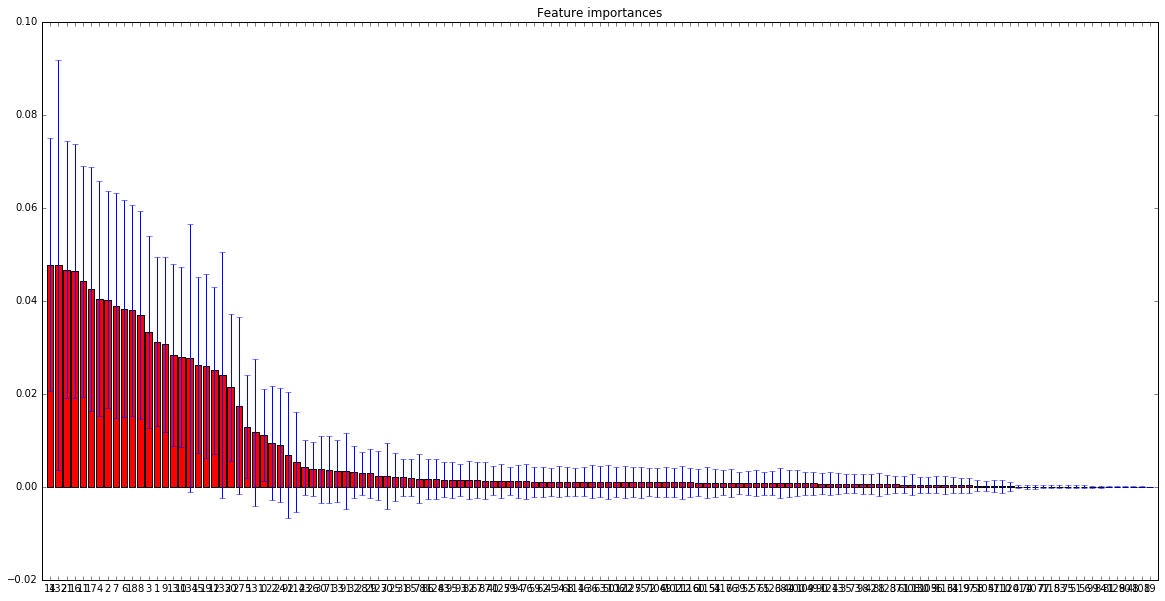

Feature ranking:
1. feature yellowReds (0.047767)
2. feature weight (0.047659)
3. feature yellowCards (0.046724)
4. feature ties (0.046400)
5. feature victories (0.044157)
6. feature redCards (0.042496)
7. feature goals (0.040451)
8. feature games (0.040279)
9. feature defeats (0.038953)
10. feature height (0.038323)
11. feature cor_meanIATredCards (0.037993)
12. feature cor_meanIATyellowCards (0.036999)
13. feature cor_meanIATyellowReds (0.033255)
14. feature cor_meanExpredCards (0.031246)
15. feature cor_meanExpyellowCards (0.030639)
16. feature cor_meanExpyellowReds (0.028397)
17. feature percentage_victories (0.027910)
18. feature percentage_ties (0.027674)
19. feature percentage_defeats (0.026181)
20. feature percentage_redCards (0.026045)
21. feature percentage_yellowReds (0.025039)
22. feature percentage_yellowCards (0.024047)
23. feature position_Attacking Midfielder (0.021398)
24. feature position_Center Back (0.017458)
25. feature position_Center Forward (0.012937)
26. featur

In [66]:
importances = clsf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clsf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1,  players_wcats.columns[f], importances[indices[f]]))


### Discussion

We note that the top 10 most discerning features are the 'natural' ones from the dataset. Moreover, the distribution between them is quite low, which means they all rank equally and none is hard to tell which is more important.

As expected, the binary features have much lower scores, as the entropy per feature is lower due to the split.

If we kept only the categorical features, the order would've been different since there is less variance among them.